In [1]:
!pip install matplotlib

In [2]:
import sys
!{sys.executable} -m pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sys
!{sys.executable} -m pip install ansys-mapdl-core


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import sys
!{sys.executable} -m pip install ansys-mapdl-core[graphics] pyvista pyvistaqt vtk


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import matplotlib.pyplot as plt
import numpy as np

from ansys.mapdl.core import launch_mapdl

mapdl = launch_mapdl(loglevel="ERROR")

mapdl.clear()
mapdl.prep7()

# Material properties-- 1020 steel in imperial
mapdl.units("BIN")  # U.S. Customary system using inches (in, lbf*s2/in, s, °F).
mapdl.mp("EX", 1, 30023280.0)
mapdl.mp("NUXY", 1, 0.290000000)
mapdl.mp("ALPX", 1, 8.388888889e-06)
mapdl.mp("DENS", 1, 7.346344000e-04)
mapdl.mp("KXX", 1, 6.252196000e-04)
mapdl.mp("C", 1, 38.6334760)

# use a thermal element type
mapdl.et(1, "SOLID70")

1

[82, 87, 110]


c:\Users\CAE\Downloads\aaryan-ansys\aaryan-ansys\aaryan-ansys\venv\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

Please install `ipywidgets`.

Falling back to a static output.
  warnings.warn(


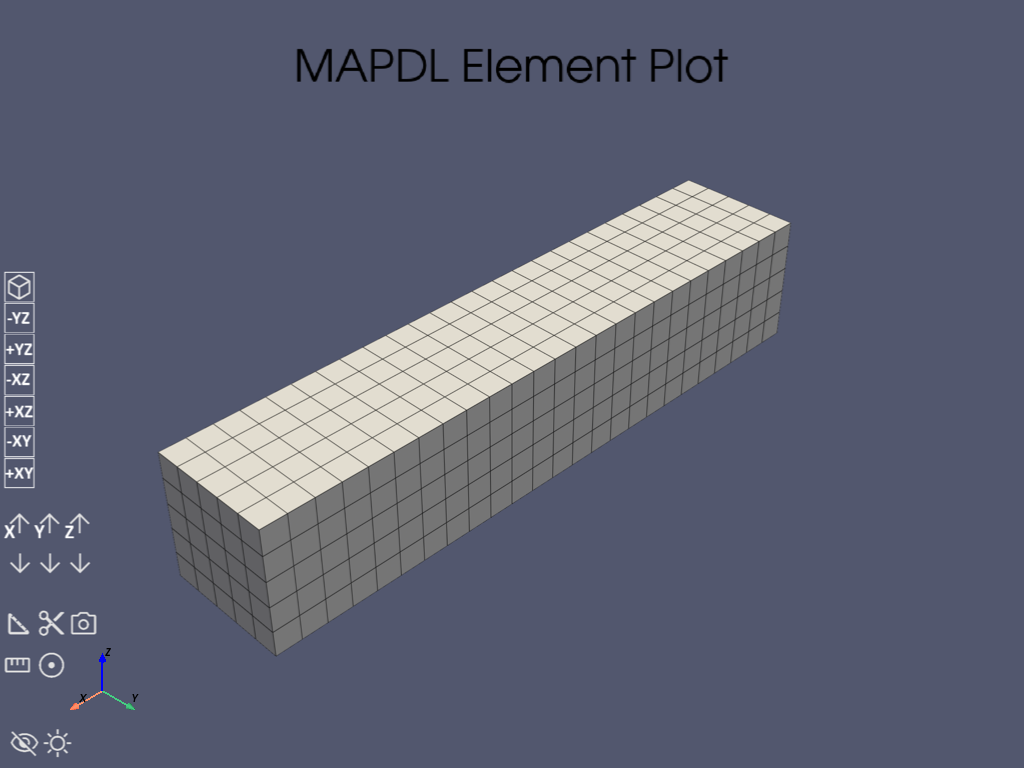

In [6]:
mapdl.block(0, 5, 0, 1, 0, 1)
mapdl.lesize("ALL", 0.2, layer1=1)

mapdl.mshape(0, "3D")
mapdl.mshkey(1)
mapdl.vmesh(1)
mapdl.eplot()

In [7]:
mapdl.run("/SOLU")
mapdl.antype(4)  # transient analysis
mapdl.trnopt("FULL")  # full transient analysis
mapdl.kbc(0)  # ramp loads up and down

# Time stepping
end_time = 1500
mapdl.time(end_time)  # end time for load step
mapdl.autots("ON")  # use automatic time stepping


# setup where the subset time is 10 seconds, time
mapdl.deltim(10, 2, 25)  # substep size (seconds)
#                          -- minimum value shorter than smallest
#                            time change in the table arrays below

# Create a table of convection times and coefficients and transfer it to MAPDL
my_conv = np.array(
    [
        [0, 0.001],  # start time
        [120, 0.001],  # end of first "flat" zone
        [130, 0.005],  # ramps up in 10 seconds
        [700, 0.005],  # end of second "flat zone
        [710, 0.002],  # ramps down in 10 seconds
        [end_time, 0.002],
    ]
)  # end of third "flat" zone
mapdl.load_table("my_conv", my_conv, "TIME")


# Create a table of bulk temperatures for a given time and transfer to MAPDL
my_bulk = np.array(
    [
        [0, 100],  # start time
        [120, 100],  # end of first "flat" zone
        [500, 300],  # ramps up in 380 seconds
        [700, 300],  # hold temperature for 200 seconds
        [900, 75],  # temperature ramps down for 200 seconds
        [end_time, 75],
    ]
)  # end of second "flat" zone
mapdl.load_table("my_bulk", my_bulk, "TIME")

In [8]:
# Force transient solve to include the times within the conv and bulk arrays
# my_tres = np.unique(np.vstack((my_bulk[:, 0], my_conv[:, 0])))[0]  # same as
mapdl.parameters["my_tsres"] = [120, 130, 500, 700, 710, 900, end_time]
mapdl.tsres("%my_tsres%")

mapdl.outres("ERASE")
mapdl.outres("ALL", "ALL")

mapdl.eqslv("SPARSE")  # use sparse solver
mapdl.tunif(75)  # force uniform starting temperature (otherwise zero)

# apply the convective load (convection coefficient plus bulk temperature)
# use "%" around table array names
mapdl.sfa(6, 1, "CONV", "%my_conv%", " %my_bulk%")

# solve
mapdl.solve()

*****  ANSYS SOLVE    COMMAND  *****

 TRANSFER SOLID MODEL BOUNDARY CONDITIONS TO FINITE ELEMENT MODEL
      SURFACE LOADS  TRANSFERRED FROM AREAS         =     25

 *** NOTE ***                            CP =       0.000   TIME= 00:00:00
 There is no title defined for this analysis.                            
   *****ANSYS VERIFICATION RUN ONLY*****
     DO NOT USE RESULTS FOR PRODUCTION

                       S O L U T I O N   O P T I O N S

   PROBLEM DIMENSIONALITY. . . . . . . . . . . . .3-D                  
   DEGREES OF FREEDOM. . . . . . TEMP
   ANALYSIS TYPE . . . . . . . . . . . . . . . . .TRANSIENT            
      SOLUTION METHOD. . . . . . . . . . . . . . .FULL                 
   EQUATION SOLVER OPTION. . . . . . . . . . . . .SPARSE             
   GLOBALLY ASSEMBLED MATRIX . . . . . . . . . . .SYMMETRIC  

 *** NOTE ***                            CP =       0.000   TIME= 00:00:00
 The conditions for direct assembly have been met.  No .emat or .erot    
 files will 

In [9]:
mapdl.post1()

FINISH SOLUTION PROCESSING


 ***** ROUTINE COMPLETED *****  CP =         0.000


   *****ANSYS VERIFICATION RUN ONLY*****
     DO NOT USE RESULTS FOR PRODUCTION

          ***** ANSYS RESULTS INTERPRETATION (POST1) *****

 *** NOTE ***                            CP =       0.000   TIME= 00:00:00
 Reading results into the database (SET command) will update the current 
 displacement and force boundary conditions in the database with the     
 values from the results file for that load set.  Note that any          
 subsequent solutions will use these values unless action is taken to    
 either SAVE the current values or not overwrite them (/EXIT,NOSAVE).    


 USE LAST SUBSTEP ON RESULT FILE  FOR LOAD CASE 0 

 SET COMMAND GOT LOAD STEP=     1  SUBSTEP=   177  CUMULATIVE ITERATION=   177
   TIME/FREQUENCY=  1500.0    
 TITLE=

c:\Users\CAE\Downloads\aaryan-ansys\aaryan-ansys\aaryan-ansys\venv\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

Please install `ipywidgets`.

Falling back to a static output.
  warnings.warn(


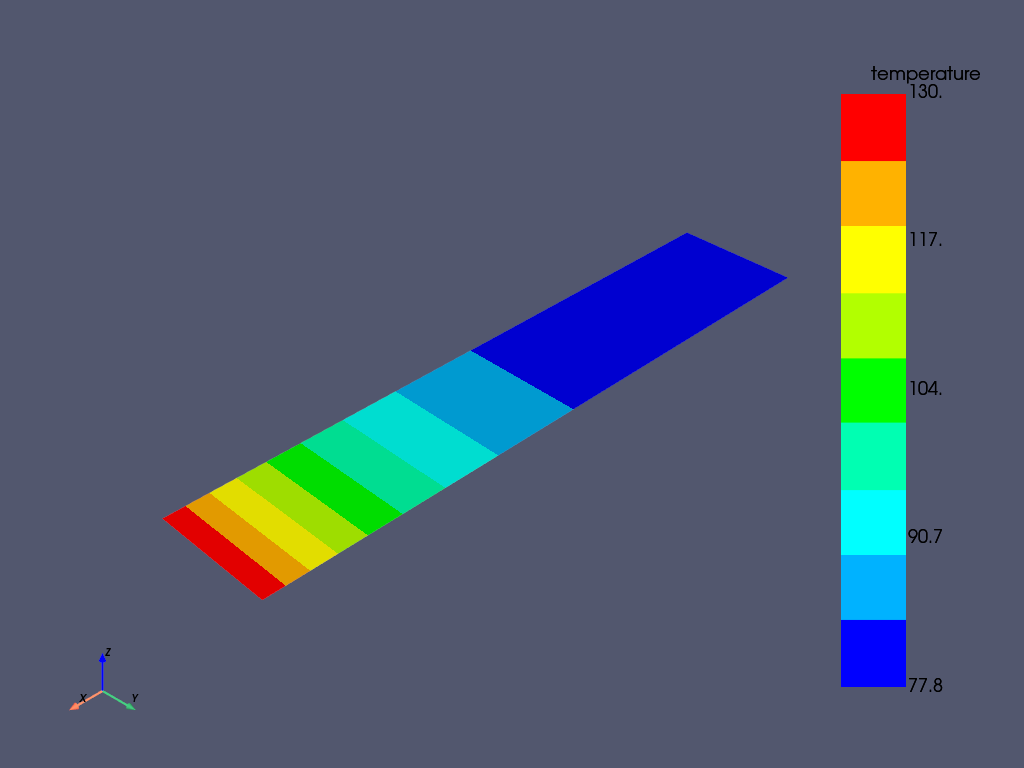

In [10]:
# get the temperature of the 30th result set
mapdl.set(1, 30)
temp = mapdl.post_processing.nodal_temperature()

# Load this result into the underlying VTK grid
grid = mapdl.mesh._grid
grid["temperature"] = temp

# generate a single horizontal slice slice along the XY plane
single_slice = grid.slice(normal=[0, 0, 1], origin=[0, 0, 0.5])
single_slice.plot(scalars="temperature")

c:\Users\CAE\Downloads\aaryan-ansys\aaryan-ansys\aaryan-ansys\venv\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

Please install `ipywidgets`.

Falling back to a static output.
  warnings.warn(


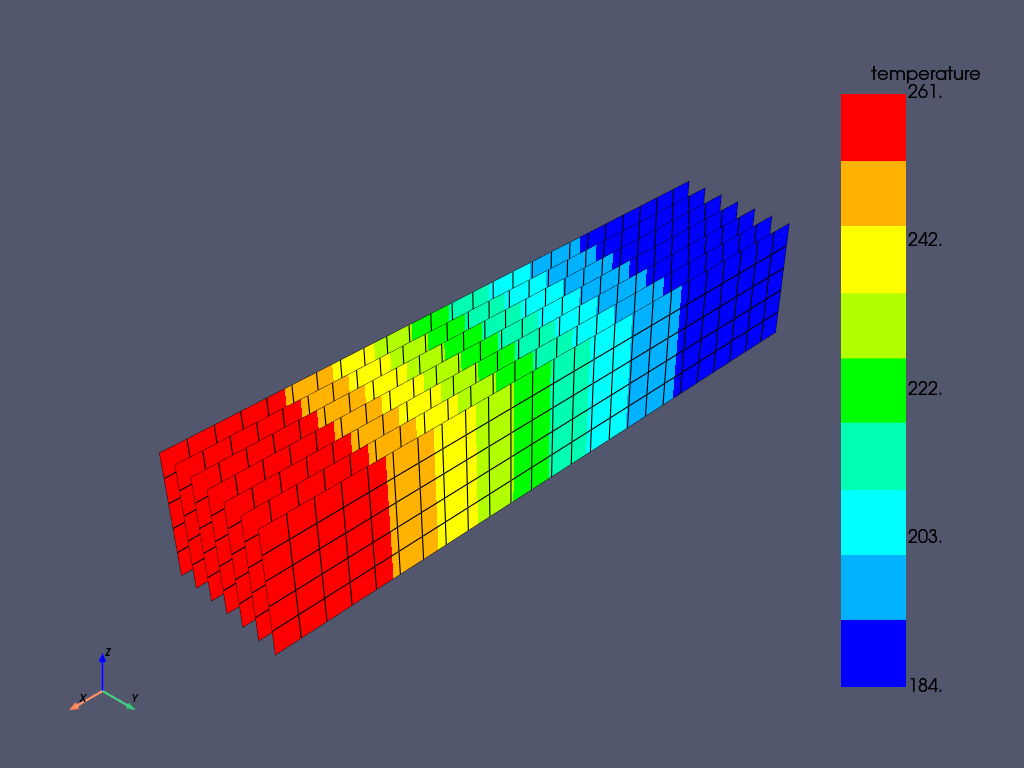

In [11]:
# get the temperature of a different result set
mapdl.set(1, 120)
temp = mapdl.post_processing.nodal_temperature()

# Load this result into the underlying VTK grid
grid = mapdl.mesh._grid
grid["temperature"] = temp

# generate a single horizontal slice slice along the XY plane
slices = grid.slice_along_axis(7, "y")
slices.plot(scalars="temperature", lighting=False, show_edges=True)

In [12]:
# for example, the temperature of Node 12 is can be retrieved simply with:
mapdl.get_value("node", 12, "TEMP")

# note that this is similar to # *GET, Par, NODE, N, Item1, IT1NUM, Item2, IT2NUM
# See the MAPDL reference for all the items you can obtain using *GET

251.05408986663676

In [13]:
nsets = mapdl.post_processing.nsets
node_temp = []
for i in range(1, 1 + nsets):
    mapdl.set(1, i)
    node_temp.append(mapdl.get_value("node", 12, "TEMP"))

# here are the first 10 temperatures
node_temp[:10]

[76.27707675716556,
 76.81799224351991,
 77.42151540097562,
 79.04838835561257,
 81.19108300049342,
 83.5670900701617,
 85.35125295387648,
 86.23266429275351,
 86.97754017604865,
 88.31275589884447]

In [14]:
# get the index of node 12 in MAPDL
idx = np.nonzero(mapdl.mesh.nnum == 12)[0][0]

# get the temperature at that index for each result
node_temp_from_post = []
for i in range(1, 1 + nsets):
    mapdl.set(1, i)
    node_temp_from_post.append(mapdl.post_processing.nodal_temperature()[idx])

# Again, the first 10 temperatures
node_temp_from_post[:10]

[np.float64(76.27707675716556),
 np.float64(76.81799224351991),
 np.float64(77.42151540097562),
 np.float64(79.04838835561257),
 np.float64(81.19108300049342),
 np.float64(83.5670900701617),
 np.float64(85.35125295387648),
 np.float64(86.23266429275351),
 np.float64(86.97754017604865),
 np.float64(88.31275589884447)]

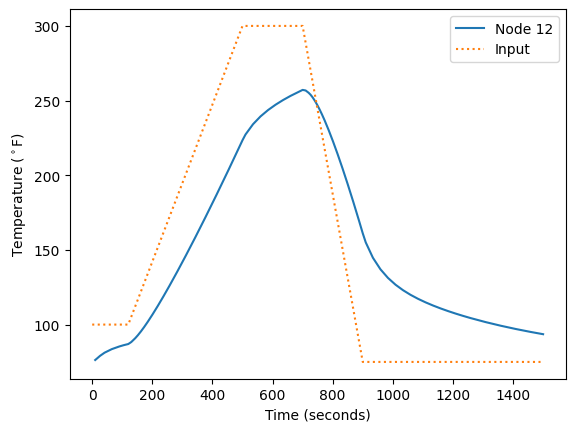

In [15]:
time_values = mapdl.post_processing.time_values
plt.plot(time_values, node_temp, label="Node 12")
plt.plot(my_bulk[:, 0], my_bulk[:, 1], ":", label="Input")
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel(r"Temperature ($^\circ$F)")
plt.show()

In [16]:
mapdl.exit()